### Differential Privacy

Differential privacy is a mathematical approach to preserving statistical and useful information in datasets without comprising the privacy of the individuals whose data is included. DP means datasets can reveal patterns which limiting any disclosure of individual information.

This is commonly achieved by adding noise to analytic outputs to mask indivudial input that influenced the calculation. DP should guarantee that a dataset will produce almost identical analytical results (such as average age) if a single entry is removed.

More formally, DP uses a randomized algorithm M which satisfies ε-differential privacy if for all datasets D₁, D₂ differing by one record, and all outputs S:   

$$Pr[M(D₁) ∈ S] ≤ e^ε × Pr[M(D₂) ∈ S]$$

This basically means that changing one of the data samples barely affects the output.

### Application to Machine Learning

DP is essential in data-hungry machine learning to preserve privacy in training data. Noise is often added either to training data (so the model doesn't learn sensitive information), or to gradients of the loss function during training. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import laplace, norm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('default')

# Anonymized datasets

Let's make a synthetic medical dataset. We will test its basic anonymization, which in this case is the lack of names, addresses and other potentially identifiable information (PII). 

In [2]:
def create_medical_dataset(n=1000):
    """Create synthetic medical data that looks anonymized but isn't"""
    ages = np.random.normal(45, 15, n).astype(int)
    ages = np.clip(ages, 18, 90)
    
    # Zip codes (let's say we're in a specific region)
    zip_codes = np.random.choice([10001, 10002, 10003, 10004, 10005], n, 
                                p=[0.3, 0.25, 0.2, 0.15, 0.1])
    
    # Medical condition (higher probability for older people)
    condition_prob = (ages - 18) / 72 * 0.6 + 0.1
    has_condition = np.random.binomial(1, condition_prob, n)
    
    # Salary (correlated with zip code and age)
    base_salary = np.random.choice([40000, 50000, 60000, 70000, 80000], n,
                                  p=[0.2, 0.3, 0.25, 0.15, 0.1])
    salary_noise = np.random.normal(0, 5000, n)
    salaries = base_salary + (ages - 30) * 500 + salary_noise
    salaries = np.clip(salaries, 25000, 120000)
    
    return pd.DataFrame({
        'age': ages,
        'zip_code': zip_codes,
        'salary': salaries.astype(int),
        'has_rare_disease': has_condition
    })

# Generate our dataset
df_medical = create_medical_dataset(1000)

# Show basic statistics
print(f"   - {len(df_medical)} patients")
print()
print(df_medical.head(20))

   - 1000 patients

    age  zip_code  salary  has_rare_disease
0    52     10001   70630                 0
1    42     10001   45621                 0
2    54     10003   71862                 0
3    67     10003   81570                 1
4    41     10001   58027                 1
5    41     10005   92945                 0
6    68     10001   90357                 1
7    56     10002   60978                 0
8    37     10003   55957                 1
9    53     10004   64348                 0
10   38     10003   54977                 0
11   38     10004   43505                 0
12   48     10002   61179                 0
13   18     10004   31338                 0
14   19     10001   57910                 0
15   36     10004   63630                 1
16   29     10002   58387                 0
17   49     10004   59734                 1
18   31     10002   47125                 1
19   23     10003   54484                 0


Let's think for a minute, what issues are inherent in such a dataset?

### Privacy attack

Imagine an attacker knows some basic information about a target, or even their neighbour, such as:
* 34 years old
* Lives in zip code 10001
* Makes around $55,000

and they want to find out if their target or neighbour has a rare disease.

In [3]:
target_age = 34
target_zip = 10001
target_salary_range = (50000, 60000)

print(f"\nSearching for matches in our 'anonymous' database...")

matches = df_medical[
    (df_medical['age'] == target_age) & 
    (df_medical['zip_code'] == target_zip) &
    (df_medical['salary'].between(target_salary_range[0], target_salary_range[1]))
]

print(f"Found {len(matches)} potential matches:")
print(matches[['age', 'zip_code', 'salary', 'has_rare_disease']])


🔍 Searching for matches in our 'anonymous' database...
Found 2 potential matches:
     age  zip_code  salary  has_rare_disease
462   34     10001   50172                 0
923   34     10001   57029                 0


We can see two close matches to the target, one of whom has the rare disease. The attacker could look for further information to confirm whether the affected individual is the original target, or try to find out who the positive case is.

### Laplace mechanism

Let's experiment with differential privacy by adding Laplace noise.

In [6]:
# The count of people with the rare disease
# This number of course shouldn't be disclosed since
# it may leak info
true_count = df_medical['has_rare_disease'].sum()

In [7]:
def laplace_mechanism(true_value, epsilon, sensitivity=1):
    """
    The Laplace Mechanism for differential privacy
    
    Args:
        true_value: The actual value to protect
        epsilon: Privacy parameter (smaller = more private)
        sensitivity: Maximum change in output from changing one record
    """
    scale = sensitivity / epsilon  # More privacy (smaller ε) = more noise
    noise = np.random.laplace(0, scale)
    return true_value + noise

print(f"\n🎲 Adding Laplace noise to protect the count...")
print("Let's try different privacy levels (epsilon values):")
print()

# Show effect of different epsilons
epsilons = [0.1, 1.0, 10.0]
print(f"{'Epsilon':<8} {'Noisy Count':<12} {'Error':<10} {'Privacy Level'}")
print("-" * 45)

for eps in epsilons:
    noisy_count = laplace_mechanism(true_count, eps)
    error = abs(noisy_count - true_count)
    
    privacy_level = "High" if eps < 1 else "Medium" if eps < 5 else "Low"
    print(f"{eps:<8} {noisy_count:<12.1f} {error:<10.1f} {privacy_level}")

print(f"\nKey insight: Lower epsilon = more privacy = more noise = less accuracy!")



🎲 Adding Laplace noise to protect the count...
Let's try different privacy levels (epsilon values):

Epsilon  Noisy Count  Error      Privacy Level
---------------------------------------------
0.1      304.1        14.9       High
1.0      319.6        0.6        Medium
10.0     318.9        0.1        Low

Key insight: Lower epsilon = more privacy = more noise = less accuracy!


In [8]:
def experiment_with_epsilon():
    """Experiment with different epsilon values"""
    
    # Change this value and re-run!
    EPSILON = 1.0  # Try 0.01, 0.1, 1.0, 10.0
    
    print(f"Experiment: ε = {EPSILON}")
    
    # Run multiple trials
    results = []
    for i in range(5):
        noisy_count = laplace_mechanism(true_count, EPSILON)
        error = abs(noisy_count - true_count)
        results.append((noisy_count, error))
        print(f"   Trial {i+1}: {noisy_count:.1f} (error: {error:.1f})")
    
    avg_error = np.mean([r[1] for r in results])
    print(f"   Average error: {avg_error:.1f}")
    
    return results

# Run the experiment
experiment_results = experiment_with_epsilon()

Experiment: ε = 1.0
   Trial 1: 319.3 (error: 0.3)
   Trial 2: 318.6 (error: 0.4)
   Trial 3: 324.4 (error: 5.4)
   Trial 4: 318.4 (error: 0.6)
   Trial 5: 318.4 (error: 0.6)
   Average error: 1.5


🔄 Running experiments across different privacy levels...


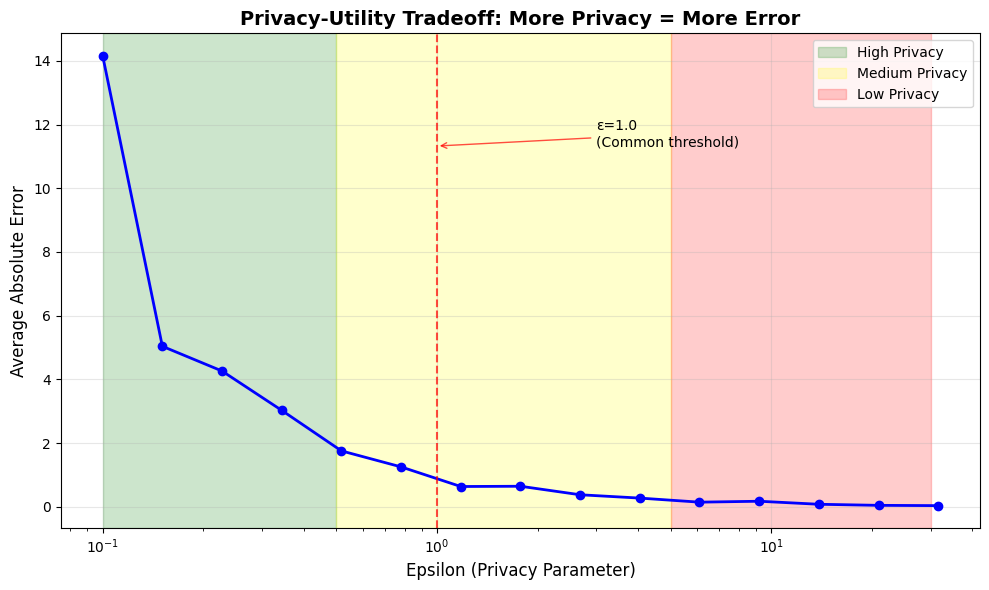

In [9]:
# Generate tradeoff data
def generate_tradeoff_data():
    epsilon_values = np.logspace(-1, 1.5, 15)  # From 0.1 to ~30
    n_trials = 20
    
    avg_errors = []
    
    for epsilon in epsilon_values:
        errors = []
        for _ in range(n_trials):
            noisy_count = laplace_mechanism(true_count, epsilon)
            error = abs(noisy_count - true_count)
            errors.append(error)
        avg_errors.append(np.mean(errors))
    
    return epsilon_values, avg_errors

print("Running experiments across different privacy levels...")
epsilons, errors = generate_tradeoff_data()

# Create the plot
plt.figure(figsize=(10, 6))
plt.semilogx(epsilons, errors, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epsilon (Privacy Parameter)', fontsize=12)
plt.ylabel('Average Absolute Error', fontsize=12)
plt.title('Privacy-Utility Tradeoff: More Privacy = More Error', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add annotations
plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.7)
plt.annotate('ε=1.0\n(Common threshold)', xy=(1.0, max(errors)*0.8), 
             xytext=(3, max(errors)*0.8), fontsize=10,
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

# Add privacy level regions
plt.axvspan(0.1, 0.5, alpha=0.2, color='green', label='High Privacy')
plt.axvspan(0.5, 5.0, alpha=0.2, color='yellow', label='Medium Privacy')  
plt.axvspan(5.0, 30, alpha=0.2, color='red', label='Low Privacy')

plt.legend()
plt.tight_layout()
plt.show()

Obviously, a high degree of privacy seems to come at the cost of accuracy. 
How might this tradeoff affect real-world deployments or analytics?

### Privacy budget

Each time we ask a question of a database, we use up part of our privacy budget. The amount we use depends on how much privacy we want to 'spend' on a question. This is the epsilon value we pass into the query.

`epsilon_budget` is the total privacy budget the database starts with.
`epsilon_spent` tracks how much has already been used.
Each query consumes some portion (epsilon) of that budget.


Since DP works by adding carefully calibrated noise (here we use Laplace) to hide individual contributions to the overall data. However, if we ask too many questions, even noisy answers can be combined to reconstruct private information.

In [10]:
class DifferentiallyPrivateDatabase:
    def __init__(self, data, epsilon_budget=1.0):
        self.data = data
        self.epsilon_budget = epsilon_budget
        self.epsilon_spent = 0.0
        print(f"DP Database created with privacy budget ε = {epsilon_budget}")
        
    def check_privacy_budget(self, epsilon_needed):
        if self.epsilon_spent + epsilon_needed > self.epsilon_budget:
            raise ValueError(f"Privacy budget exceeded! "
                           f"Spent: {self.epsilon_spent:.2f}, "
                           f"Need: {epsilon_needed}, "
                           f"Budget: {self.epsilon_budget}")
    
    def count_query(self, condition_column, condition_value, epsilon):
        """Count records satisfying a condition"""
        print(f"Running count query with ε = {epsilon}")
        self.check_privacy_budget(epsilon)
        
        # True count
        true_count = (self.data[condition_column] == condition_value).sum()
        
        # Add Laplace noise (sensitivity = 1 for counting)
        noisy_count = laplace_mechanism(true_count, epsilon, sensitivity=1)
        noisy_count = max(0, int(round(noisy_count)))  # Counts can't be negative
        
        self.epsilon_spent += epsilon
        print(f"   True count: {true_count}")
        print(f"   DP count: {noisy_count}")
        print(f"   Remaining budget: ε = {self.remaining_budget():.2f}")
        
        return noisy_count
    
    def remaining_budget(self):
        return self.epsilon_budget - self.epsilon_spent

# Create our DP database
dp_db = DifferentiallyPrivateDatabase(df_medical, epsilon_budget=1.0)

DP Database created with privacy budget ε = 1.0


In [11]:
print(f"\nQuery 1: How many people have the rare disease?")
try:
    disease_count = dp_db.count_query('has_rare_disease', 1, epsilon=0.3)
    print(f"Query successful!")
except ValueError as e:
    print(f"{e}")

print(f"\nQuery 2: How many people live in zip code 10001?")
try:
    zip_count = dp_db.count_query('zip_code', 10001, epsilon=0.3)
    print(f"Query successful!")
except ValueError as e:
    print(f"{e}")

print(f"\nQuery 3: How many people are exactly 34 years old?")
try:
    age_count = dp_db.count_query('age', 34, epsilon=0.5)
    print(f"Query successful!")
except ValueError as e:
    print(f"{e}")

print(f"\nQuery 4: One more query...")
print("What happens if we try another query?")
try:
    another_count = dp_db.count_query('zip_code', 10002, epsilon=0.3)
    print(f"Query successful!")
except ValueError as e:
    print(f"{e}")
    print("This is privacy budget depletion in action!")


Query 1: How many people have the rare disease?
🔍 Running count query with ε = 0.3
   True count: 319
   DP count: 321
   Remaining budget: ε = 0.70
Query successful!

Query 2: How many people live in zip code 10001?
🔍 Running count query with ε = 0.3
   True count: 296
   DP count: 296
   Remaining budget: ε = 0.40
Query successful!

Query 3: How many people are exactly 34 years old?
🔍 Running count query with ε = 0.5
Privacy budget exceeded! Spent: 0.60, Need: 0.5, Budget: 1.0

Query 4: One more query...
What happens if we try another query?
🔍 Running count query with ε = 0.3
   True count: 246
   DP count: 248
   Remaining budget: ε = 0.10
Query successful!


### Exercises

1. Experiment with parameters
    * Modify the EPSILON, try 0.01, 0.1, 10.0, 100.0
    * At what point does the noise become excessive?
2. Create your own attack
    * Add more quasi-indentifiers to the medical dataset
    * Try to identify individuals with 2-3 attributes
    * How unique are people in high-dimensional data?
3. Think like an attacker
    * Question: If you were trying to break DP, where would you start?
   